In [1]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import pandas as pd
import numpy as np
#stuff to import

In [2]:
#the dataset
earthquake_data = pd.read_csv("Japan earthquakes 2001 - 2018.csv")

In [3]:
#Random Forest Pipeline
#feature engineering using the time column- this should improve RMSE. Splits time into its specific components
earthquake_data['year'] = pd.to_datetime(earthquake_data['time']).dt.year
earthquake_data['month'] = pd.to_datetime(earthquake_data['time']).dt.month
earthquake_data['day'] = pd.to_datetime(earthquake_data['time']).dt.day
earthquake_data['hour'] = pd.to_datetime(earthquake_data['time']).dt.hour

#unneeded columns, likely won't be useful in magnitude prediction
irrelevant_cols = ['id', 'updated', 'place', 'locationSource', 'magSource', 'time']
data_cleaned = earthquake_data.drop(columns=irrelevant_cols)

X = data_cleaned.drop(columns=['mag'])
y = data_cleaned['mag']

numerical_cols = X.select_dtypes(include=['float64', 'int']).columns
categorical_cols = X.select_dtypes(include=['object']).columns
num_transformer = SimpleImputer(strategy='median')
cat_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
preprocessor = ColumnTransformer(
    transformers=[
        ('num', num_transformer, numerical_cols),
        ('cat', cat_transformer, categorical_cols)
    ],
    remainder='drop'
)


#model and pipeline definition
rfr = RandomForestRegressor(random_state=42)
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', rfr)
])


X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

#display the results, RMSE and R^2
print(f"RMSE: {rmse}")
print(f"R²: {r2}")


RMSE: 0.18695684815489208
R²: 0.7564873052331434


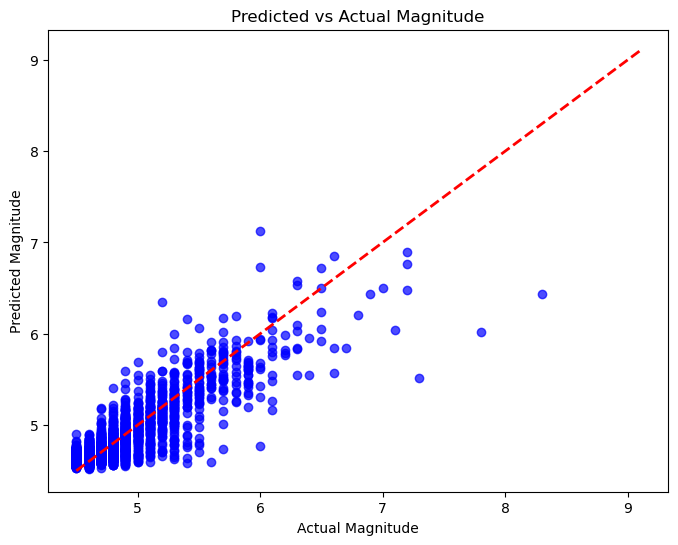

In [4]:
#now that the model is trained, we do visualization!
import matplotlib.pyplot as plt


#Plotting actual magnitude vs predicted magnitude
plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.7, color='blue')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--', linewidth=2)
plt.xlabel('Actual Magnitude')
plt.ylabel('Predicted Magnitude')
plt.title('Predicted vs Actual Magnitude')
plt.show()

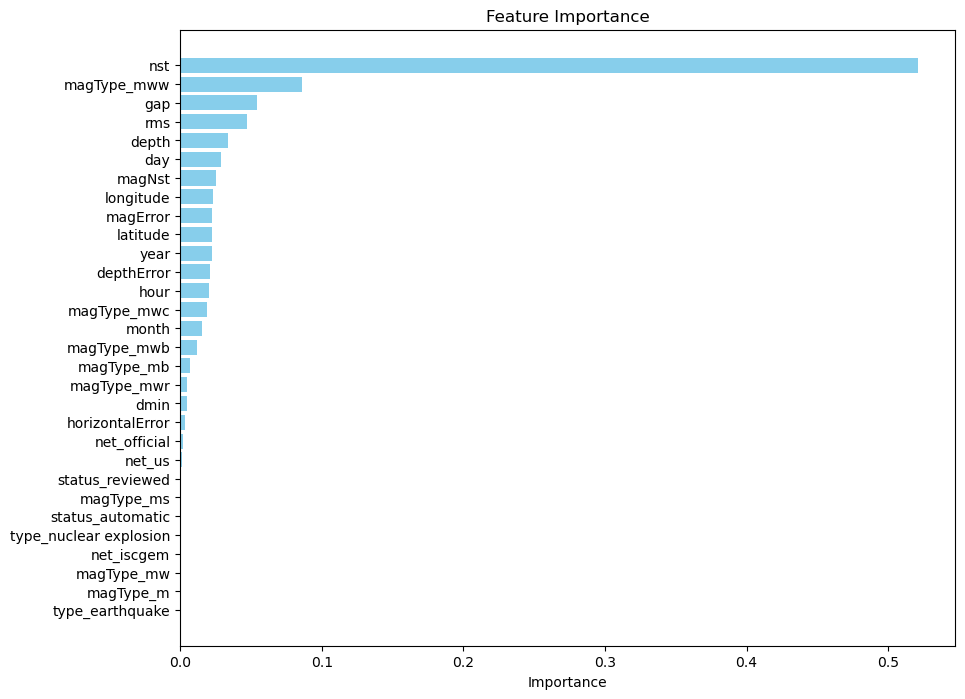

In [5]:
#Plotting feature importance- this shows which features are most important to predictions

feature_names = numerical_cols.tolist() + list(pipeline.named_steps['preprocessor']
                                               .named_transformers_['cat']
                                               .named_steps['onehot']
                                               .get_feature_names_out(categorical_cols))

feature_importances = pipeline.named_steps['model'].feature_importances_
sorted_idx = np.argsort(feature_importances)
plt.figure(figsize=(10, 8))
plt.barh(np.array(feature_names)[sorted_idx], feature_importances[sorted_idx], color='skyblue')
plt.xlabel('Importance')
plt.title('Feature Importance')
plt.show()
